# Final project report - Metadynamics

### Names: Netanel Bachar & David Stark
### IDs: ??? & 203865761

Perform Metadynamics simulations at $298K$ for a Ar atom in the double well potential energy surface:   
<center>$V(x)=Ax^4-Bx^2$</center>   
where $A=4.11\cdot10^{20}Jm^{-4}, B=8.22Jm^{-2}$



## Introduction - the problem of sampling the whole potential surface - transition is a rare event

We can clearly see that the barrier between the two wells is pretty big.
<img src="Final/WellPotential.png">   

If we use the previous MC approach, we will sample only one of the wells because landing on somewhat better potential is difficult because of the large barrier. Making a few consecutive steps towards the second well is statistically unlikely especially if we consider the acceptance probability for a step to (a much) higher potential.  
Increasing the translation step size could help but we can see it still takes many steps "to get lucky". Also, more often than not, we don't know how the potential energy surface looks like to "easily" pick a decent translation step size.
<img src="Final/PositionMC.png">   


For the MD approach, the particle is stuck in the well and oscillates according to the starting position/energy. In some cases, the particle might start with enough energy to overcome a barrier, but we can't always be sure especially if we don't know what the potential surface looks like.
<img src="Final/PositionEnergyMD.png">  

## Using metadynamics to enhance sampling

Using this approach...

# Code for the parts

## Metadynamics

### First

## Introduction

### Well potential energy surface

Text(0, 0.5, 'potential [J]')

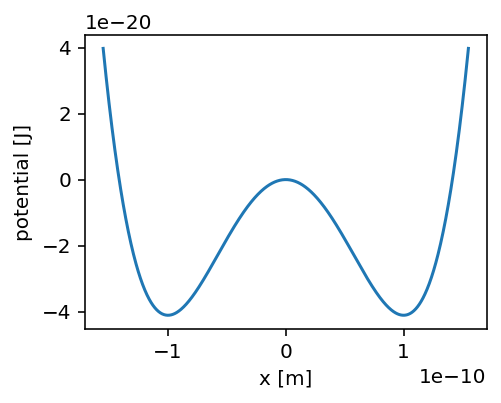

In [4]:
import matplotlib.pyplot as plt
import numpy as np

A = 4.11e20
B = 8.22
x = np.linspace(-1.55e-10, 1.55e-10, 1000)
V = A*x**4 - B*x**2

fig = plt.figure(figsize=(3.6,2.7), dpi=144)
plt.plot(x,V)
plt.xlabel('x [m]')
plt.ylabel('potential [J]')
# plt.savefig('Final/WellPotential.png', bbox_inches='tight')

### Particles position for two translation step sizes using MC

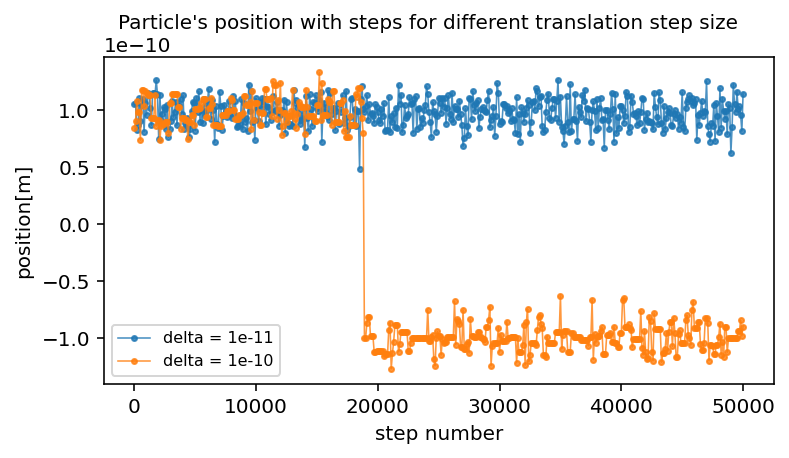

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sim import Simulation

R = np.array([[1.05e-10, 0.0, 0.0]])
mass = np.array([6.6335209e-26])
deltas = [1e-11, 1e-10]

sims_pos = list()

for delta in deltas:
    sim = Simulation(dt=1.0e-15, L=1.0, Nsteps=50000, R=R, mass=mass, deltaMC=delta,
                 kind=["Ar"], ftype="DoubleWell", printfreq=100,  outname="MCsim.log")
    sim.runMC(**{ "A": 4.11e20 , "B": 8.22 })
    sim.__del__()

    positions = list()
    with open('sim.xyz') as file:
        for line in file:
            if 'Step' in line:
                step = float(line.split()[1])
            if 'Ar' in line:
                positions.append([step,float(line.split()[1])])
            
    positions = np.array(positions)
    sims_pos.append(positions)

fig = plt.figure(figsize=(6,3), dpi=144)
fig.suptitle("Particle's position with steps for different translation step size", fontsize=10)
plt.xlabel('step number')
plt.ylabel('position[m]')

for positions in sims_pos:
    x,y = positions.T
    plt.plot(x,y, linewidth=0.8, linestyle='-', marker='o', markersize=2.5, alpha=0.8)
plt.legend(['delta = 1e-11', 'delta = 1e-10'], fontsize=8)

# plt.savefig('Final/PositionMC.png', bbox_inches='tight')

### Particles position and energy with time

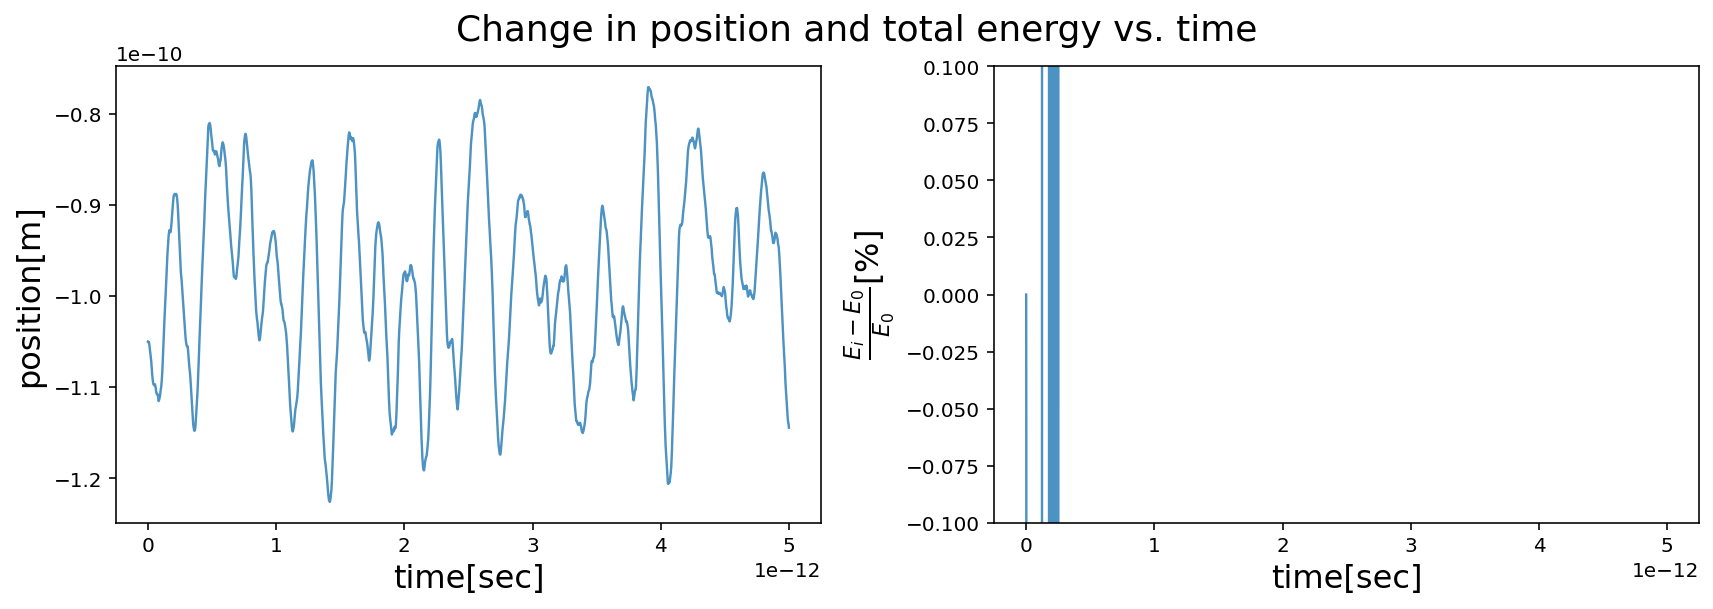

In [20]:
from sim import Simulation
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4.5), dpi=144)
plt.subplots_adjust(hspace=0.1)
ax1.set_xlabel('time[sec]', fontsize=16)
ax1.set_ylabel('position[m]', fontsize=16)
ax2.set_xlabel('time[sec]', fontsize=16)
ax2.set_ylabel(r'$\frac{E_i-E_0}{E_0}[\%]$', fontsize=16)
fig.suptitle('Change in position and total energy vs. time', fontsize=18, y=0.93)

R = np.array([[-1.05e-10, 0.0, 0.0]]) # In meters
mass = np.array([6.6335209e-26]) # Argon mass 
dt = 1.0e-15
sim = Simulation(dt=dt, L=1, Nsteps=5000, R=R, mass=mass, kind=["Ar"], ftype="DoubleWell", printfreq=1)
sim.runMeta(**{ "A": 4.11e20 , "B": 8.22 })
sim.__del__()

positions = list()
with open('sim.xyz') as file:
    for line in file:
        if 'Step' in line:
            step = float(line.split()[1])
        if 'Ar' in line:
            positions.append([step*dt,float(line.split()[1])])
positions = np.array(positions)
x,y = positions.T
ax1.plot(x,y, linewidth=1.2, linestyle='-', alpha=0.8)

energies = list()
with open('sim.log') as file:
    file.readline()
    for line in file:
        ener = line.split()
        kin, pot, tot = float(ener[1]), float(ener[2]), (float(ener[1])+float(ener[2]))
        energies.append([kin, pot, tot])
energies = np.array(energies).T

change_energy = (energies[2]-energies[2][0])*100/energies[2][0]
ax2.plot(x, change_energy, linewidth=1.2, linestyle='-', alpha=0.8)
ax2.set_ylim([-0.1,0.1])
plt.tight_layout()

# plt.savefig('Final/PositionEnergyMD.png', bbox_inches='tight')

In [24]:
positions[2000][1] - positions[1999][1]

2.0009999999996398e-14

### Validation of langevine dynamics through temperature

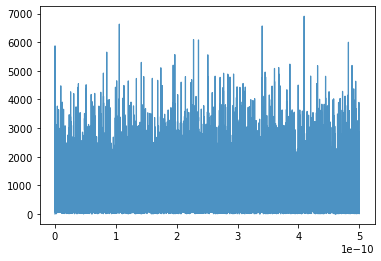

In [18]:
from scipy.constants import Boltzmann as BOLTZMANN

change_energy = energies[0]*2 / BOLTZMANN
plt.plot(x, change_energy, linewidth=1.2, linestyle='-', alpha=0.8)